In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, ConnectionPatch
import matplotlib.transforms as mplt
import models
import mscthesis
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
import pandas as pd
import geopandas as gpd
import sampers
import regions
import geostat
import resultcomp

In [195]:
geotweets = mscthesis.read_geotweets('sweden').set_index('userid')

In [196]:
tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 10].index)

# Distance v Probabilty

In [197]:
def distance_vs_probability(tweets):
    home = tweets[tweets['label'] == 'home']
    if home.shape[0] > 1:
        home = home.iloc[0]
    region_counts = tweets.groupby('region').size()
    region_probs = region_counts / region_counts.sum()
    regions = tweets.groupby('region').head(1).set_index('region').sort_index()
    distances_km = pd.Series(
        (6371.0088 * haversine_distances(
            np.radians(regions[['latitude', 'longitude']]),
            np.radians([[home.latitude, home.longitude]]),
        ))[:,0],
        index=regions.index,
    )
    return pd.DataFrame.from_dict(dict(
        distance = distances_km,
        probability = region_probs
    ))

In [198]:
distances_from_home = []
for uid in geotweets.index.get_level_values(level=0).unique():
    tweets = geotweets.loc[uid]
    if tweets.shape[0] < 2:
        continue
    distances_from_home.append(distance_vs_probability(tweets).assign(userid=uid))
distances_from_home = pd.concat(distances_from_home).reset_index().set_index(['userid', 'region'])

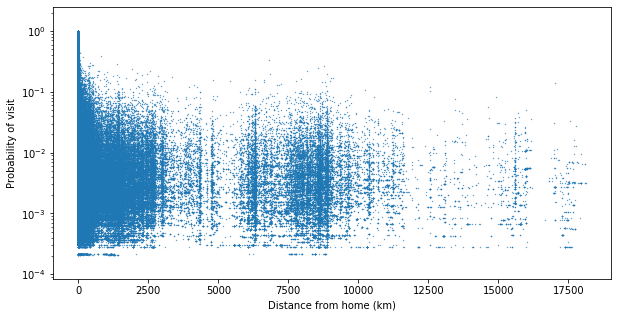

In [199]:
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel("Distance from home (km)")
plt.ylabel("Probability of visit")
ax.set_yscale("log")
_ = ax.scatter(distances_from_home.distance, distances_from_home.probability, s=0.1)

# Sampers bounding boxes

In [171]:
westbbox = regions.gbgcity.to_crs("EPSG:3035")
westzones = sampers.read_shp(sampers.shps['west']).to_crs("EPSG:3035")
westzones = westzones[westzones.geometry.is_valid]
westzones = gpd.clip(
    westzones,
    gpd.GeoDataFrame(geometry=westbbox),
)

eastbbox = regions.sthlmcity.to_crs("EPSG:3035")
eastzones = sampers.read_shp(sampers.shps['east']).to_crs("EPSG:3035")
esatzones = eastzones[eastzones.geometry.is_valid]
eastzones = gpd.clip(
    eastzones,
    gpd.GeoDataFrame(geometry=eastbbox),
)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPanda

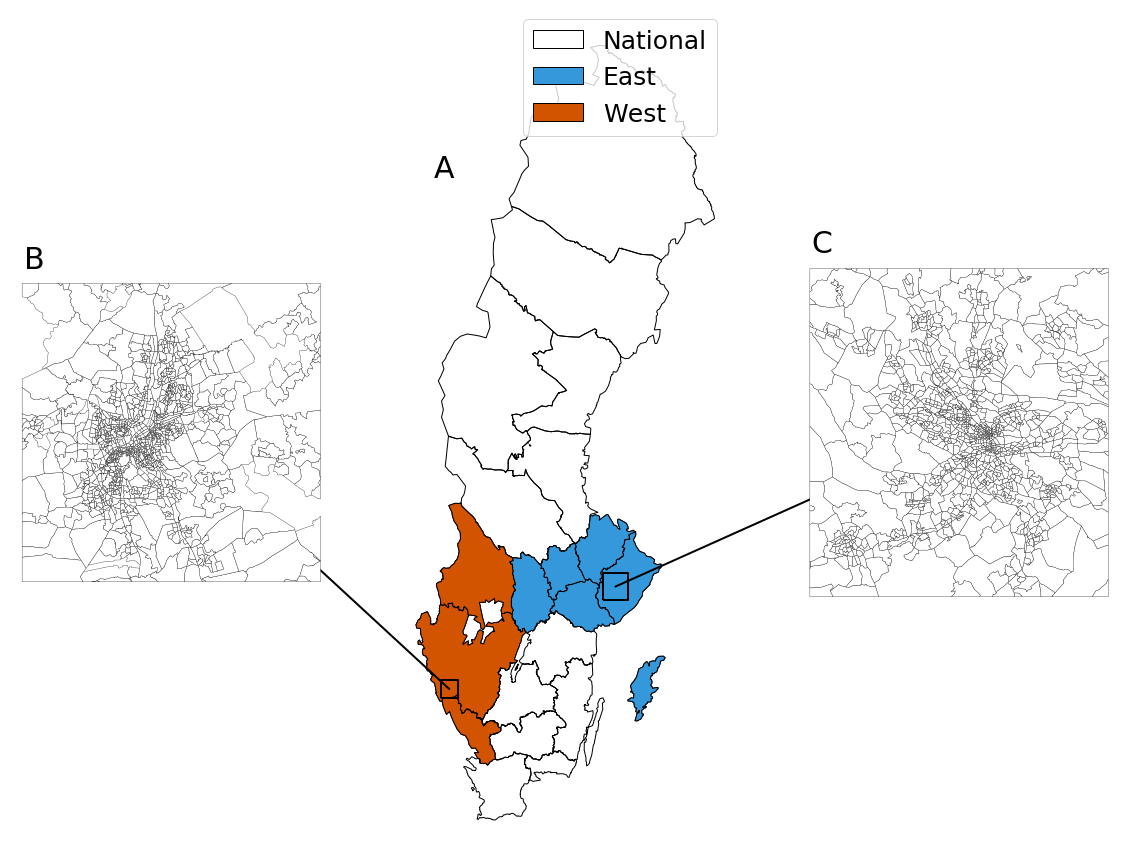

In [217]:
fig, axes = plt.subplots(1,3, figsize=(20, 20))

# Sampers bounding boxes
sampers.bbox['national'].to_crs("EPSG:3035").plot(
    ax=axes[1],
    edgecolor='black', 
    facecolor='none', 
)
sampers.bbox['east'].to_crs("EPSG:3035").plot(
    ax=axes[1],
    facecolor='#3498db',
    edgecolor='black',
)
sampers.bbox['west'].to_crs("EPSG:3035").plot(
    ax=axes[1], 
    facecolor='#d35400',
    edgecolor='black'
)

# City highlights (bbox)
regions.sthlmcity.to_crs("EPSG:3035").plot(
    ax=axes[1], 
    facecolor='none',
    edgecolor='black',
    linewidth=2,
)
regions.gbgcity.to_crs("EPSG:3035").plot(
    ax=axes[1], 
    facecolor='none',
    edgecolor='black',
    linewidth=2,
)

# City highlights (line from bbox to zoom)
axes[1].add_artist(ConnectionPatch(
    xyA=(eastbbox.centroid.x, eastbbox.centroid.y),
    xyB=(eastbbox.centroid.x, eastbbox.centroid.y),
    coordsA="data",
    coordsB="data",
    axesA=axes[1],
    axesB=axes[2],
    color='black',
    linewidth=2,
))

axes[1].add_artist(ConnectionPatch(
    xyA=(westbbox.centroid.x, westbbox.centroid.y),
    xyB=(westbbox.centroid.x, westbbox.centroid.y),
    coordsA="data",
    coordsB="data",
    axesA=axes[0],
    axesB=axes[1],
    color='black',
    linewidth=2,
))

# City highlights (zoom)
eastzones.plot(ax=axes[2], facecolor='white', edgecolor='black', linewidth=0.3)
westzones.plot(ax=axes[0], facecolor='white', edgecolor='black', linewidth=0.3)

axes[0].set_axis_off()
axes[0].zorder = 2
axes[0].text(.05, 1, "B", transform=axes[0].transAxes, fontsize='30')

axes[1].set_axis_off()
axes[1].zorder = 1
axes[1].text(.1, .8, "A", transform=axes[1].transAxes, fontsize='30')

axes[2].set_axis_off()
axes[2].zorder = 2
axes[2].text(.05, 1, "C", transform=axes[2].transAxes, fontsize='30')

axes[1].legend(
    handles=[
        Patch(facecolor='none', edgecolor='black', label='National'),
        Patch(facecolor='#3498db', edgecolor='black', label='East'),
        Patch(facecolor='#d35400', edgecolor='black', label='West')
    ], 
    loc='upper right',
    fontsize='25'
)


# Population representation

In [100]:
twitter_homes = pd.read_csv("./../../dbs/sweden/homelocations.csv")
twitter_homes = gpd.GeoDataFrame(
    twitter_homes,
    crs="EPSG:3006",
    geometry=gpd.points_from_xy(twitter_homes['x'], twitter_homes['y']),
)

In [101]:
# smallest polygon containing all points
mask = regions.counties.convex_hull.unary_union.convex_hull
census_homes = geostat.load(mask=regions.counties.convex_hull.unary_union.convex_hull)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [102]:
counties = regions.counties.set_index('ID')
municipalities = gpd.read_file("../../dbs/sweden_municipalities/sweden_municipalities.shp").rename(columns={"KnKod": "ID"}).set_index("ID")

In [103]:
print(counties.crs.srs)
print(municipalities.crs.srs)
print(census_homes.crs.srs)
print(twitter_homes.crs.srs)

EPSG:3035
epsg:3006
epsg:3035
EPSG:3006


In [104]:
twitter_homes = twitter_homes.to_crs(census_homes.crs)
municipalities = municipalities.to_crs(census_homes.crs)

In [151]:
def align_populations(alignment_regions, twitter, census):
    a = alignment_regions.assign(
        twitter = gpd.sjoin(alignment_regions, twitter, how="inner", op='intersects').groupby('ID').size(),
        census = gpd.sjoin(alignment_regions, census, how="inner", op='intersects').groupby('ID').sum().population,
    )
    # Some regions might not have recorded population. Ex Haparanda
    a = a.fillna(0)
    a = a.assign(
        twitter_perc = a.twitter / a.twitter.sum(),
        census_perc = a.census / a.census.sum(),
    )
    a = a.assign(
        perc_diff = a.twitter_perc - a.census_perc
    )

    return a

In [152]:
counties = align_populations(counties, twitter_homes, census_homes)
municipalities = align_populations(municipalities, twitter_homes, census_homes)

Text(0.05, 0.8, 'B')

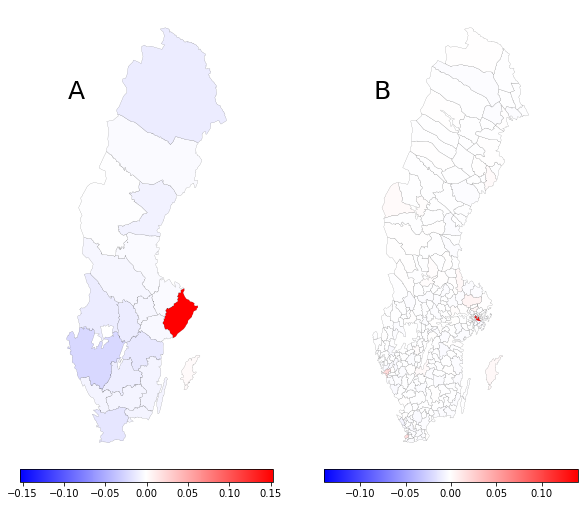

In [318]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_axis_off()
ax2.set_axis_off()
plot_cfg = {
    "column": "perc_diff",
    "legend": True,
    "edgecolor": "black",
    "linewidth": 0.1,
    "cmap": "bwr",
}
legend_kwds = {
    "orientation": "horizontal",
    "pad": 0.01,
    "shrink": 1.0,
}

counties_limit = np.max(np.abs(counties.perc_diff))
counties.plot(
    ax=ax1, 
    vmin=-counties_limit, 
    vmax=counties_limit,
    **plot_cfg,
    legend_kwds=dict(legend_kwds)
)
ax1.text(.05, .8, "A", transform=ax1.transAxes, fontsize='25')

municipalities_limit = np.max(np.abs(municipalities.perc_diff))
municipalities.plot(
    ax=ax2, 
    vmin=-municipalities_limit, 
    vmax=municipalities_limit,
    **plot_cfg,
    legend_kwds=dict(legend_kwds)
)
ax2.text(.05, .8, "B", transform=ax2.transAxes, fontsize='25')

Text(0.05, 0.9, 'B')

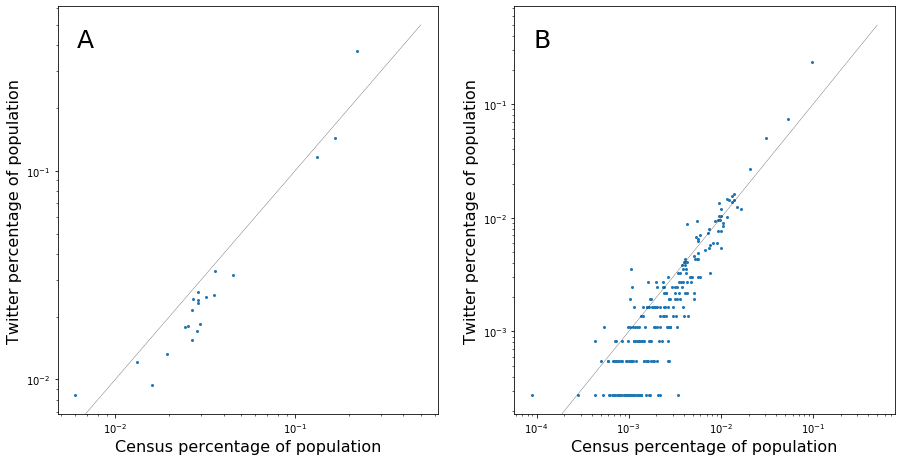

In [323]:
fig, axes = plt.subplots(1,2, figsize=(15, 7.5))

scatter_style = {
    "kind": "line",
    "x": "census_perc",
    "y": "twitter_perc",
    "loglog": True,
    "marker": "o",
    "markersize": 2,
    "linestyle": "None",
    "legend": False,
}
pd.DataFrame(counties).plot(
    ax=axes[0],
    **scatter_style,
)

pd.DataFrame(municipalities).plot(
    ax=axes[1],
    **scatter_style,
)
for ax in axes:
    ax.plot([0,0.5], [0,0.5], color='black', linewidth=0.25)
    ax.set_xlabel('Census percentage of population', fontsize=16)
    ax.set_ylabel('Twitter percentage of population', fontsize=16)
axes[0].text(.05, .9, "A", transform=axes[0].transAxes, fontsize='25')
axes[1].text(.05, .9, "B", transform=axes[1].transAxes, fontsize='25')

# Distance distribution

In [15]:
run_id = ["zipf_and_dist2", "baseline_new"]

In [16]:
dms = resultcomp.read_distance_metrics(directories=run_id)

In [19]:
dms.loc[('national', 'zipf_and_dist2')].model_mean.sum()

<ipython-input-19-ddd711160a9a>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  dms.loc[('national', 'zipf_and_dist2')].model_mean.sum()


0.00021499879353261152